<a target="_blank" href="https://colab.research.google.com/github/skojaku/adv-net-sci/blob/main/notebooks/exercise-m05-clustering.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Hands-on: Clustering

In [1]:
# If you are using Google Colab, uncomment the following line to install igraph
# !sudo apt install libcairo2-dev pkg-config python3-dev
# !pip install pycairo cairocffi
# !pip install igraph

## Modularity maximization

Let us showcase how to use `igraph` to detect communities with modularity. We will use the Karate Club Network as an example.

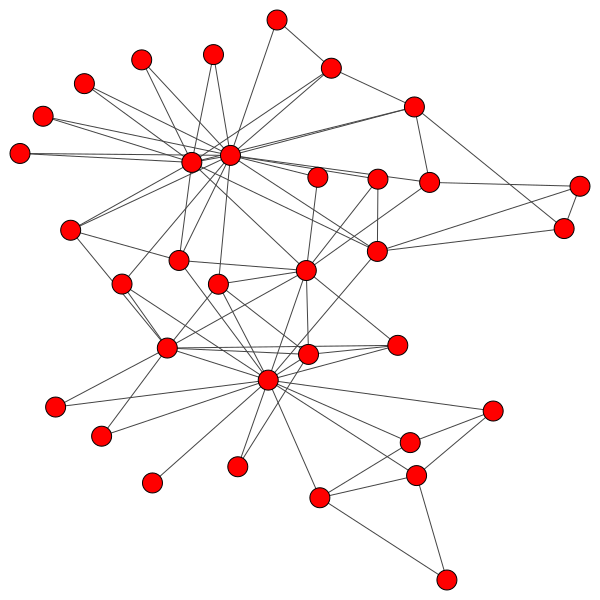

In [2]:
import igraph
g = igraph.Graph.Famous("Zachary")
igraph.plot(g, vertex_size=20)

When it comes to maximizing modularity, there are a variety of algorithms to choose from.
Two of the most popular ones are the `Louvain` and `Leiden` algorithms, both of which are implemented in `igraph`. The Louvain algorithm has been around for quite some time and is a classic choice, while the Leiden algorithm is a newer bee that often yields better accuracy. For our example, we'll be using the `Leiden` algorithm, and I think you'll find it really effective!

In [3]:
communities = g.community_leiden(resolution=1, objective_function= "modularity")

What is `resolution`? It is a parameter that helps us tackle the resolution limit of the modularity maximization algorithm {footcite}`fortunato2007resolution`!
In simple terms, when we use the resolution parameter $\rho$, the modularity formula can be rewritten as
 follow:

$$
Q(M) = \frac{1}{2m} \sum_{i=1}^n \sum_{j=1}^n \left(A_{ij} - \rho \frac{k_i k_j}{2m}\right) \delta(c_i, c_j)
$$

Here, the parameter $\rho$ plays a crucial role in balancing the positive and negative parts of the equation.
The resolution limit comes into play because of the diminishing effect of the negative term as the number of edges $m$ increases.
The parameter $\rho$ can adjust this balance and allow us to circumvent the resolution limit.

What is `communities`? This is a list of communities, where each community is represented by a list of nodes by their indices.

In [4]:
print(communities)


Clustering with 34 elements and 4 clusters
[0] 0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21
[1] 4, 5, 6, 10, 16
[2] 8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33
[3] 23, 24, 25, 27, 28, 31


Let us visualize the communities by coloring the nodes in the graph.

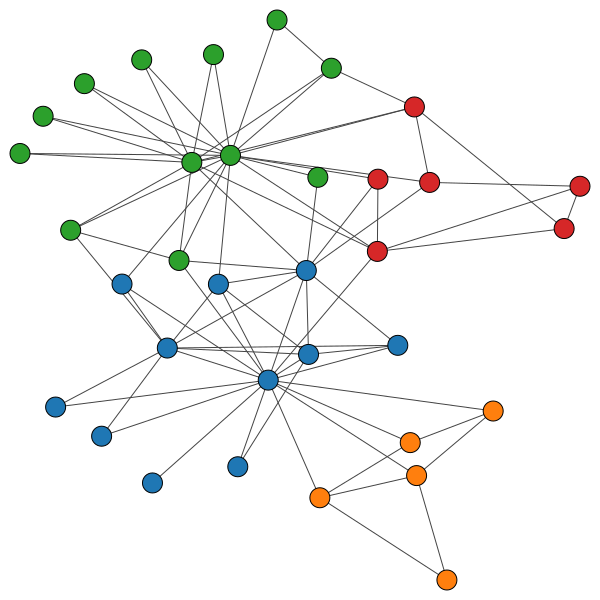

In [5]:
import seaborn as sns
community_membership = communities.membership
palette = sns.color_palette().as_hex()
igraph.plot(g, vertex_color=[palette[i] for i in community_membership])

- `community_membership`: This is a list of community membership for each node.
- `palette`: This is a list of colors to use for the communities.
- `igraph.plot(g, vertex_color=[palette[i] for i in community_membership])`: This plots the graph 'g' with nodes colored by their community.

### Exercise 01 🏋️‍♀️💪🧠

1. Select a network of your choice from [Netzschleuder](https://networks.skewed.de/). For convenience, choose a network of nodes less than 5000.
2. Download the csv version of the data by clicking something like "3KiB" under `csv` column.
3. Unzip the file and find "edges.csv", open it with a text editor to familiarize yourself with the format.
4. Load the data using `pandas`.
5. Get the source and target nodes from the data to create an edge list.
6. Construct a graph from the edge list, either using `igraph` or `scipy`.
7. Find communities by maximizing the modularity and visualize them.
8. Try at least three different values of the resolution parameter and observe how the community structure changes.

In [6]:
# Your code here

## Stochstic Block Model

Let us turn the SBM as our community detection tool using [graph-tool](https://graph-tool.skewed.de/). This is a powerful library for network analysis, with a focus on the stochastic block model.

In [7]:
#
# Uncomment the following code if you are using Google Colab
#
#!wget https://downloads.skewed.de/skewed-keyring/skewed-keyring_1.0_all_$(lsb_release -s -c).deb
#!dpkg -i skewed-keyring_1.0_all_$(lsb_release -s -c).deb
#!echo "deb [signed-by=/usr/share/keyrings/skewed-keyring.gpg] https://downloads.skewed.de/apt $(lsb_release -s -c) main" > /etc/apt/sources.list.d/skewed.list
#!apt-get update
#!apt-get install python3-graph-tool python3-matplotlib python3-cairo
#!apt purge python3-cairo
#!apt install libcairo2-dev pkg-config python3-dev
#!pip install --force-reinstall pycairo
#!pip install zstandard

We will identify the communities using the stochastic block model as follows.
First, we will convert the graph object in igraph to that in graph-tool.

In [8]:
import graph_tool.all  as gt
import numpy as np
import igraph

# igraph object
g = igraph.Graph.Famous("Zachary")

# Set random seed for reproducibility
np.random.seed(42)

# Convert the graph object in igraph to that in graph-tool
edges = g.get_edgelist()
r, c = zip(*edges)
g_gt = gt.Graph(directed=False)
g_gt.add_edge_list(np.vstack([r, c]).T)

Then, we will fit the stochastic block model to the graph.

In [9]:
# Fit the stochastic block model
state = gt.minimize_blockmodel_dl(
     g_gt,
     state_args={"deg_corr": False, "B_min":2, "B_max":10},
)
b = state.get_blocks()

/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/graph_tool/inference/blockmodel.py:390: UserWarning: unrecognized keyword arguments: ['B_min', 'B_max']
  warnings.warn("unrecognized keyword arguments: " +


- `B_min` and `B_max` are the minimum and maximum number of communities to consider.
- `deg_corr` is a boolean flag to switch to the degree-corrected SBM {footcite}`karrer2011stochastic`.


```{note}
Here's a fun fact: the likelihood maximization on its own can't figure out how many communities there should be. But `graph-tool` has a clever trick to circumvent this limitation.
`graph-tool` actually fits multiple SBMs, each with a different number of communities. Then, it picks the most plausible one based on a model selection criterion.
```

Let's visualize the communities to see what we got.

In [10]:
# Convert the block assignments to a list
community_membership = b.get_array()

# The community labels may consist of non-consecutive integers, e.g., 10, 8, 1, 4, ...
# So we reassign the community labels to be 0, 1, 2, ...
community_membership = np.unique(community_membership, return_inverse=True)[1]
community_membership

array([4, 4, 4, 2, 0, 0, 0, 2, 3, 3, 0, 2, 2, 2, 3, 3, 0, 2, 3, 3, 3, 2,
       3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 5, 5])

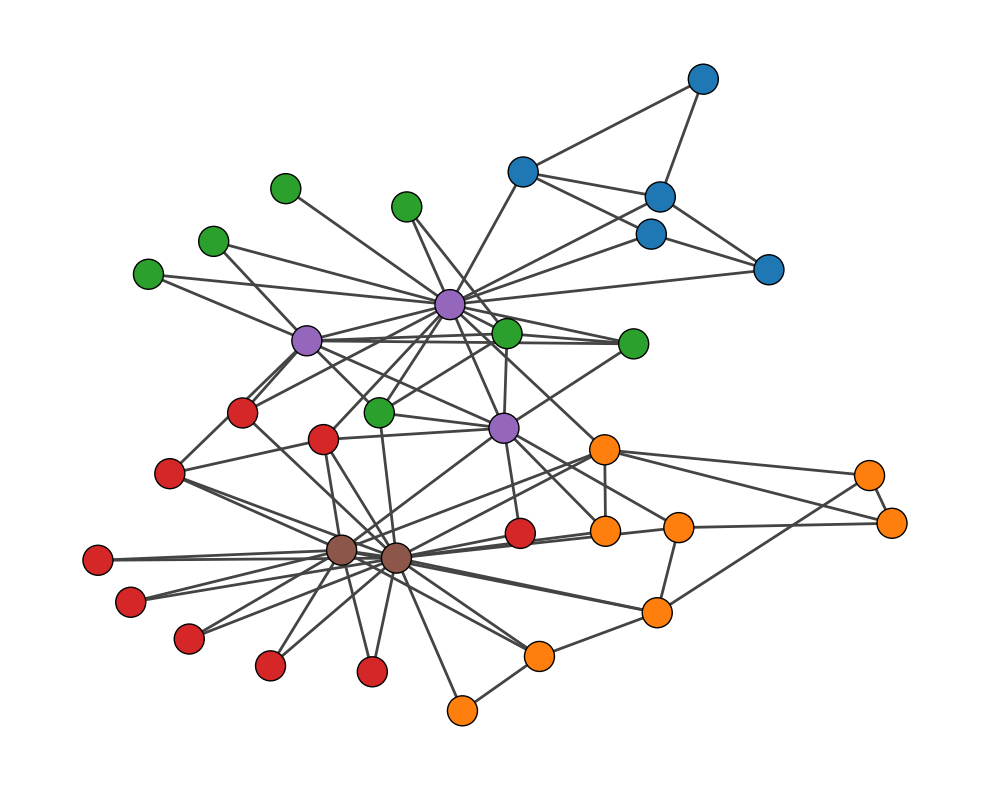

In [11]:
# Create a color palette
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette().as_hex()
# Plot the graph with nodes colored by their community
fig, ax = plt.subplots(figsize=(10, 8))
igraph.plot(
    g,
    target=ax,
    vertex_color=[palette[i] for i in community_membership],
)
plt.axis('off')
plt.tight_layout()
plt.show()

What we're seeing here isn't a failure at all. In fact, it's the best partition according to our stochastic block model. The model has discovered something called a **core-periphery structure** {footcite}`borgatti2000models`. Let me break that down:

- Think of a major international airport (the core) and smaller regional airports (the periphery).
- Major international airports have many flights connecting to each other (densely connected).
- Smaller regional airports have fewer connections among themselves (sparsely connected).
- Many regional airports have flights to major hubs (periphery connected to the core).

That's exactly what our model found in this network.

If we look at the adjacency matrix, we would see something that looks like an upside-down "L". This shape is like a signature for core-periphery structures.

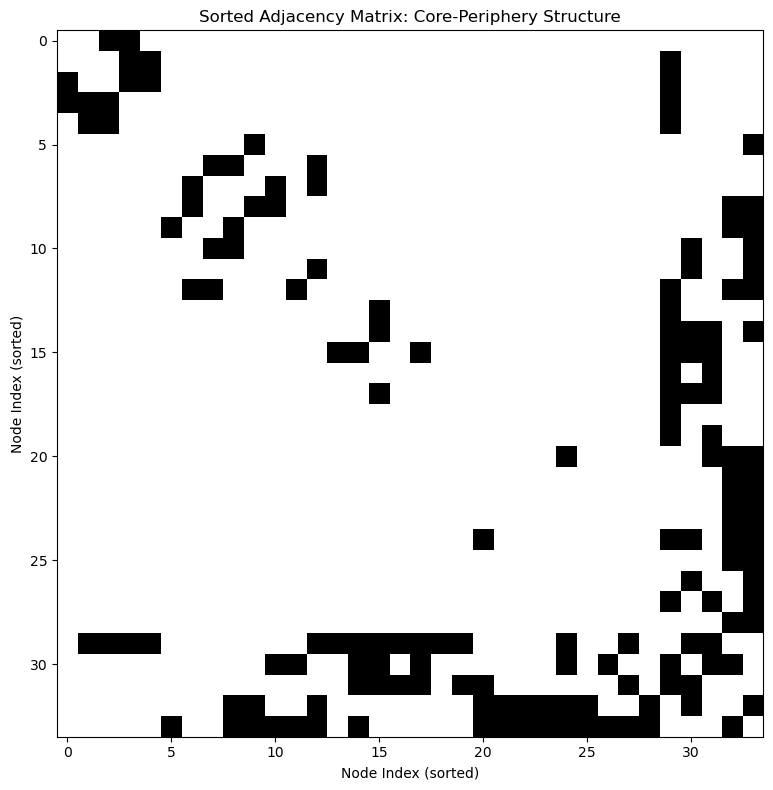

In [12]:
# Convert igraph Graph to adjacency matrix
A = np.array(g.get_adjacency().data)

# Sort nodes based on their community (core first, then periphery)
sorted_indices = np.argsort(community_membership)
A_sorted = A[sorted_indices][:, sorted_indices]

# Plot the sorted adjacency matrix
plt.figure(figsize=(10, 8))
plt.imshow(A_sorted, cmap='binary')
plt.title("Sorted Adjacency Matrix: Core-Periphery Structure")
plt.xlabel("Node Index (sorted)")
plt.ylabel("Node Index (sorted)")

plt.tight_layout()
plt.show()

### Exercise 02 🏋️‍♀️💪🧠

1. Select a network of your choice from [Netzschleuder](https://networks.skewed.de/). For convenience, choose a network of nodes less than 5000.
2. Download the csv version of the data by clicking something like "3KiB" under `csv` column.
3. Unzip the file and find "edges.csv", open it with a text editor to familiarize yourself with the format.
4. Load the data using `pandas`.
5. Get the source and target nodes from the data to create an edge list.
6. Construct a graph from the edge list, either using `igraph` or `scipy`.
7. Find communities by fitting the stochastic block model and visualize them.
8. Try `deg_corr=True` and compare the results with those from `deg_corr=False`.

```{footbibliography}
```